In [85]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib as plt
import os

%pylab inline

if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

import os
import json

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# IDEA:
## Customers are more likely to ride longtrip biking on weekends than on weekdays
Citi bike customers may use the bike for commute to work on weekdays. So the proportion of long trip(longtrip/shorttrip) on weekends should be higer than weekdays. Here I assumed that the tripduration less than 10 minutes is commute to work which is short trip. And the tripduration over 10 minutes is long trip. 

# NULL HYPOTHESIS:
## The proportion of long trip biking on weekdays is _the same_ or _higher_  than the proportion of long trip biking on weekends

# _$H_0$_ : $\frac{L_{\mathrm{weekend}}}{S_{\mathrm{weekend}}} <= \frac{L_{\mathrm{weekday}}}{S_{\mathrm{weekday}}}$
# _$H_1$_ : $\frac{L_{\mathrm{weekend}}}{S_{\mathrm{weekend}}}> \frac{L_{\mathrm{weekday}}}{S_{\mathrm{weekday}}}$

or identically:

# _$H_0$_ : $\frac{L_{\mathrm{weekend}}}{S_{\mathrm{weekend}}} - \frac{L_{\mathrm{weekday}}}{S_{\mathrm{weekday}}} <= 0 $
# _$H_1$_ : $\frac{L_{\mathrm{weekend}}}{S_{\mathrm{weekend}}} - \frac{L_{\mathrm{weekday}}}{S_{\mathrm{weekday}}}> 0$
## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [74]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [75]:
datestring = '201401'
getCitiBikeCSV(datestring)

file in place, you can continue


In [76]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df['date'] = pd.to_datetime(df['starttime'])
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,471,2014-01-01 00:00:06,2014-01-01 00:07:57,2009,Catherine St & Monroe St,40.711174,-73.996826,263,Elizabeth St & Hester St,40.717290,-73.996375,16379,Subscriber,1986,1,2014-01-01 00:00:06
1,1494,2014-01-01 00:00:38,2014-01-01 00:25:32,536,1 Ave & E 30 St,40.741444,-73.975361,259,South St & Whitehall St,40.701221,-74.012342,15611,Subscriber,1963,1,2014-01-01 00:00:38
2,464,2014-01-01 00:03:59,2014-01-01 00:11:43,228,E 48 St & 3 Ave,40.754601,-73.971879,2022,E 59 St & Sutton Pl,40.758491,-73.959206,16613,Subscriber,1991,1,2014-01-01 00:03:59
3,373,2014-01-01 00:05:15,2014-01-01 00:11:28,519,Pershing Square N,40.751884,-73.977702,526,E 33 St & 5 Ave,40.747659,-73.984907,15938,Subscriber,1989,1,2014-01-01 00:05:15
4,660,2014-01-01 00:05:18,2014-01-01 00:16:18,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,436,Hancock St & Bedford Ave,40.682166,-73.953990,19830,Subscriber,1990,1,2014-01-01 00:05:18


In [77]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date'],
      dtype='object')

In [78]:
df.drop(['starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'], axis=1, inplace=True)

In [23]:
df.head(10)

,tripduration,date
0,471,2014-01-01 00:00:06
1,1494,2014-01-01 00:00:38
2,464,2014-01-01 00:03:59
3,373,2014-01-01 00:05:15
4,660,2014-01-01 00:05:18
5,330,2014-01-01 00:05:55
6,261,2014-01-01 00:06:04
7,337,2014-01-01 00:06:41
8,429,2014-01-01 00:07:33
9,1025,2014-01-01 00:08:27


Text(0.5,1,'Different Tripduration')

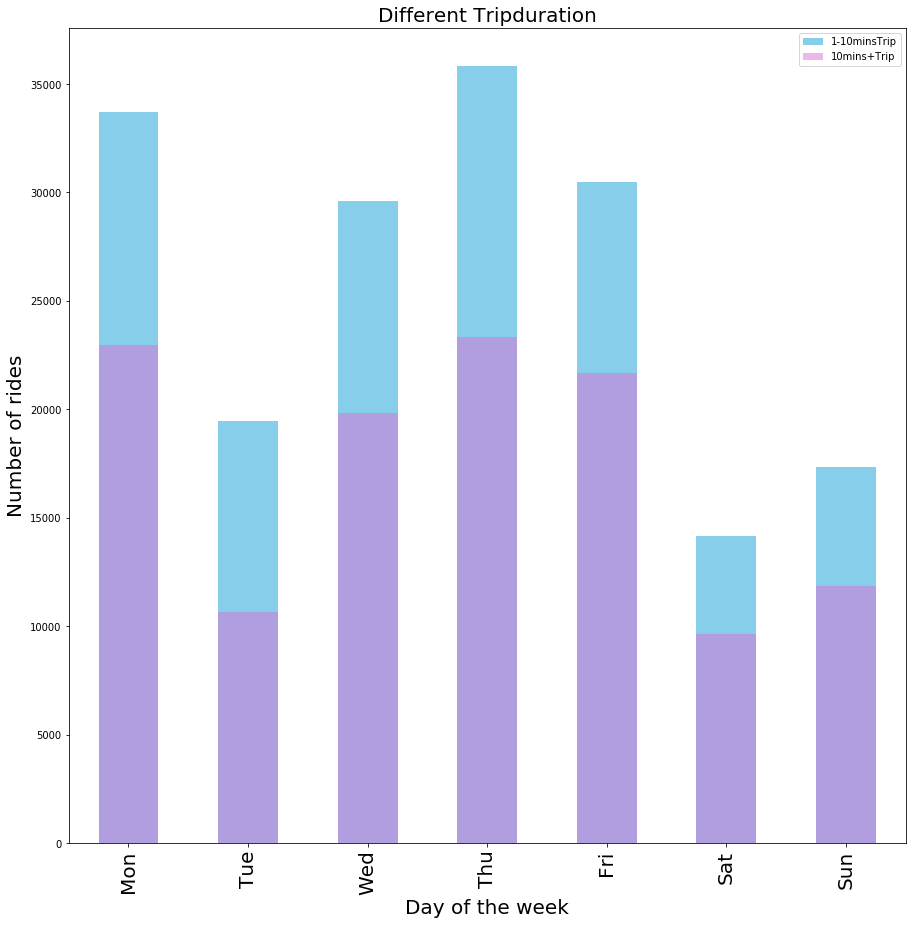

In [127]:
fig = pl.figure(figsize(15,15))


(df['date'][df['tripduration'] <= 600].groupby([df['date'].dt.weekday]).count()).plot(kind="bar",
                                                                                          color='skyblue', 
                                                                                         label='1-10minsTrip')
# (df['date'][(df['tripduration'] > 600) & (df['tripduration'] <= 900)].groupby([df['date'].dt.weekday]).count()).plot(kind="bar", 
                                                                                              
#                                                                                               color='IndianRed',
                                                                                        
#                                                                                               label='10-15minsTrip')

# (df['date'][(df['tripduration'] > 900) & (df['tripduration'] <= 1800)].groupby([df['date'].dt.weekday]).count()).plot(kind="bar", 
                                                                                              
#                                                                                               color='Turquoise',
                                                                                              
#                                                                                               label='15-30minsTrip')

ax =(df['date'][df['tripduration'] >600].groupby([df['date'].dt.weekday]).count()).plot(kind="bar",
                                                                                          color='Orchid', 
                                                                                        alpha=0.5, 
                                                                                         label='10mins+Trip')



tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
pl.legend()
ax.set_ylabel ("Number of rides",fontsize=20)
ax.set_xlabel ("Day of the week",fontsize=20)
pl.title("Different Tripduration",fontsize=20)

## Figure 1: Distribution of Citibike bikers by Tripduration in January 2014, absolute counts